# Convolutional Online PCA

This is a development +  experiment notebook for using the results obtained in the PCA notebook and constructing useable modules out of them. The actual lib for using these is the COPCA.py file 

In [3]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal, MultivariateNormal, Categorical
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, transforms
from torch.nn.utils.clip_grad import clip_grad_value_, clip_grad_norm_

import string
from random import *
import re
import math
import time

import subprocess, os, glob
import time

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from dennytools.silence import *

device = 'cuda:3'
print (device)

print (os.getcwd())

print(torch.__version__)

cuda:3
/home/tbjackso/Online PCA
1.2.0


In [65]:

class Convolutor(nn.Module):
    def __init__(self, in_size, out_channels, kernel_size, stride=1):
        super(Convolutor, self).__init__()
        
        (k0, k1) = kernel_size
        (c,h,w) = in_size
        
        # D1 = product of kernel dims and input channels
        D = c * k0 * k1
        hp = (h-k0)//stride+1
        wp = (w-k1)//stride+1
        L = hp*wp
        
        self.L = L
        self.D = D
        self.C = c
        self.K = kernel_size
        self.G = out_channels
        
        self.unfold = nn.Unfold(kernel_size, stride=stride)
        self.fold_forward  = nn.Fold((hp,wp), (1,1), stride=1)
        self.Process = None
        
    def forward(self, x):
        (bs,c,h,w) = x.shape
        x1 = self.unfold(x).transpose(1,2).contiguous().view(-1, self.D)
        yuf = self.Process(x1)
        y = self.fold_forward(yuf.view(bs,self.L,self.G).transpose(1,2))
        return y
    
    def learn(self, x):
        x1 = self.unfold(x).view(-1, self.D)
        self.Process.learn(x1)
    
    def params(self):
        return self.Process.params()
    
    
    

def RandomSON(n):
    M = np.random.randn(n,n)
    Q,R = np.linalg.qr(M)
    return Q
    

class OPCA(nn.Module):
    def __init__(self, inputs, outputs, eta=1e-3, gamma=0):
        super().__init__()
        
        if (inputs < outputs):
            raise ValueError("Inputs must be >= outputs. Got {} < {}".format(inputs, outputs))
        
        self.dummy = nn.Parameter(torch.zeros(1))
        
        # OPCA
        self.register_buffer('T', torch.tensor(RandomSON(inputs)[:,:outputs]).float())
        self.register_buffer('N', torch.diag(torch.arange(outputs,0,-1).float()))
        self.register_buffer('eta', torch.tensor(eta))
        
        # Centering
        self.register_buffer('mu', torch.zeros(inputs))
        self.register_buffer('gamma', torch.tensor(gamma))
        
    def forward(self, xin):
        
        # Centering
        x = xin-self.mu
        xt = torch.einsum('bi,ij->bj', [x, self.T])
 
        if (self.training):
            self.learn(xin)
        
        return xt
    
    def learn(self, xin):
        
        # Centering
        x = xin-self.mu
        
        # EMA
        self.mu *= (1-self.gamma)
        self.mu += self.gamma*(x.mean(0))
        
        # Batched OPCA
        xt = torch.einsum('bi,ij->bj', [x, self.T])
        X = torch.einsum('bk,bl->bkl',[xt, xt]).mean(0)
        C = torch.einsum('ik,kl->il', [self.N, X])
        Tgrad = -self.T@(C-C.transpose(0,1))
        
        self.T += self.eta*Tgrad
    
    def params(self):
        return self.T
    
class COPCA(Convolutor):
    def __init__(self, in_size, out_channels, kernel_size, stride=1, eta=1e-3, gamma=0):
        super().__init__(in_size, out_channels, kernel_size, stride)
        
        self.Process = OPCA(self.D, out_channels, eta, gamma)
        


In [66]:
BS = 100

# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=BS, shuffle=True, pin_memory=False)

# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=False, transform=transforms.Compose([
        transforms.ToTensor()
    ])), batch_size=BS, shuffle=True, pin_memory=False)

# Training dataset
big_batch = torch.utils.data.DataLoader(
    datasets.MNIST(root='./MNIST', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor()
                   ])), batch_size=500, shuffle=True, pin_memory=False)

In [70]:
def makeNet(device, Gs=[15,20,25,30,30], eta=1e-3, gamma=0):

    L0 = COPCA((1,28,28), Gs[0], (3,3), eta=eta, gamma=gamma).eval()
    L0.to(device)

    L1 = COPCA((Gs[0],26,26), Gs[1], (3,3), stride=2, eta=eta, gamma=gamma).eval()
    L1.to(device)

    L2 = COPCA((Gs[1],12,12), Gs[2], (3,3), stride=2, eta=eta, gamma=gamma).eval()
    L2.to(device)

    L3 = COPCA((Gs[2],5,5), Gs[3], (3,3), eta=eta, gamma=gamma).eval()
    L3.to(device)
    
    L4 = COPCA((Gs[3],3,3), Gs[4], (3,3), eta=eta, gamma=gamma).eval()
    L4.to(device)

    Ls = [L0, L1, L2, L3, L4]
    return Ls

    
def doEpoch(Ls, data_loader, learn):
    device = next(Ls[0].parameters()).device
    for (data, label) in data_loader:
        p = data.to(device)
        for i,L in enumerate(Ls):
            # Calculate Forward
            x = L(p)
            # Learn
            if (learn is True or learn == i):
                L.learn(p)
                
            p = x

            

def train(Ls, data_loader, rounds, epochs, layer_learn=False, hardness=False, verbose=False):

    device = next(Ls[0].parameters()).device

    epochs = epochs*len(Ls) if (layer_learn) else epochs
    hard = np.zeros((rounds*epochs+1, len(Ls)))
    
    print ("Gathering Initial Statistics...")
    if (hardness):
        for i in range(len(Ls)):
            hard[0, i] = MeasureHardness(Ls[:i+1], Ns, 30, data_loader, epochs=5, lr=5e-3, verbose=verbose)

    try:
        for r in range(rounds):
            s = time.time()
            print ("Round: {}/{}".format(r+1,rounds))

            for e in range(epochs):
                    
                if (layer_learn):
                    doEpoch(Ls, data_loader, e//len(Ls))
                else:
                    doEpoch(Ls, data_loader, True)

                # Measure hardness of each layer
                if (hardness):
                    lhards = []
                    for i in range(len(Ls)):
                         lhards.append(MeasureHardness(Ls[:i+1], 30, data_loader, epochs=5, lr=5e-3, verbose=verbose))
                    hard[epochs*r+e+1, i] = lhards
                    pstr = "Epoch {} : "+", ".join(["{:.2f}"]*len(Ls))
                    print (pstr.format(*([e]+lhards)))
                else:
                    print ("Epoch: {}".format(e))
            e = time.time()
            print ("Round {} runtime: {}\n".format(r,e-s))
            
    except KeyboardInterrupt:
        hard = hard[:(r*epochs)+e]
    
    if (hardness):
        return hard



            
# TODO 
# Define proper class for this deep conv net?
# Write function that trains one or two layer neural network against the outpits of
# the predictive learned behaviour and measures how quickly learning takes place
class FCNet(nn.Module):
    def __init__(self, inputs, hidden, classes):
        super(FCNet, self).__init__()
#         self.L1 = nn.Linear(inputs, hidden)
#         self.L2 = nn.Linear(hidden, classes)
        self.L  = nn.Linear(inputs, classes)
        self.inputs = inputs
        
    def forward(self, x):
        x1 = x.view(-1, self.inputs)
#         x2 = F.relu(self.L1(x1))
        x3 = self.L(x1)
#         x3 = self.L2(x2)
        return x3

def forward(Ls, data, full=False):
    device = next(Ls[0].parameters()).device
    dd = data.to(device)
    
    Ys = [dd]

    for l,L in enumerate(Ls):

        dd = L(dd)

        Ys.append(dd)
        
    if (full):
        return Ys
    else:
        return Ys[-1]

def MeasureHardness(Ls, hidden, data_loader, test=None, epochs=10, lr=1e-3, verbose=False):
    device = next(Ls[0].parameters()).device
    
    net = FCNet(Ls[-1].G*Ls[-1].L, hidden, 10).to(device)
    opt = optim.Adam(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    
    with silence(not verbose):
        hardness = 0
        for e in range(epochs):
            Tloss = 0
            Tacc = 0
            for data, label in data_loader:
                data = data.to(device)
                label = label.to(device)

                x = forward(Ls, data)

                opt.zero_grad()
                y = net(x)

                bloss = loss(y, label)
                Tloss += bloss.item()
                bloss.backward()

                opt.step()

                acc = (y.argmax(-1) == label).float().mean().item()

                Tacc += acc/len(data_loader)
                
            if (test is not None):
                Tacc = 0
                for (data, label) in test:
                    
                    data = data.to(device)
                    label = label.to(device)
                    
                    x = forward(Ls, data)
                    y = net(x)
                    
                    acc = (y.argmax(-1) == label).float().mean().item()

                    Tacc += acc/len(test)
            
            hardness += Tacc/epochs

            print ("Epoch: {} Acc: {:.2f} Loss: {:.2f}".format(e, 100*Tacc, Tloss))
            
    return hardness


In [ ]:
Ls = makeNet(device, Gs=[4,4,4,4,4])
hardpre = []
for i in range(len(Ls)):
    hardpre.append(MeasureHardness(Ls[:i+1], 30, train_loader, epochs=5, lr=5e-3, verbose=False))
    print ("Layer {}: {}".format(i, hardpre[-1]))
    
hard = train(Ls, train_loader, 1, 2100, layer_learn=False, hardness=False, verbose=True)

hardpost = []
for i in range(len(Ls)):
    hardpost.append(MeasureHardness(Ls[:i+1], 30, train_loader, epochs=5, lr=5e-3))
    print ("Layer {}: {}".format(i, hardpost[-1]))
    
print ()
for i in range(5):
    h1 = hardpre[i]
    h2 = hardpost[i]
    print ("Layer {}: {:.4f} -> {:.4f}".format(i,h1,h2))

Layer 0: 0.913916648154457
Layer 1: 0.9095333153208092
Layer 2: 0.8215699795385183
Layer 3: 0.679793316913148
Layer 4: 0.2712399928892649
Gathering Initial Statistics...
Round: 1/1
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Epoch: 21
Epoch: 22
Epoch: 23
Epoch: 24
Epoch: 25
Epoch: 26
Epoch: 27
Epoch: 28
Epoch: 29
Epoch: 30
Epoch: 31
Epoch: 32
Epoch: 33
Epoch: 34
Epoch: 35
Epoch: 36
Epoch: 37
Epoch: 38
Epoch: 39
Epoch: 40
Epoch: 41
Epoch: 42
Epoch: 43
Epoch: 44
Epoch: 45
Epoch: 46
Epoch: 47
Epoch: 48
Epoch: 49
Epoch: 50
Epoch: 51
Epoch: 52
Epoch: 53
Epoch: 54
Epoch: 55
Epoch: 56
Epoch: 57
Epoch: 58
Epoch: 59
Epoch: 60
Epoch: 61
Epoch: 62
Epoch: 63
Epoch: 64
Epoch: 65
Epoch: 66
Epoch: 67
Epoch: 68
Epoch: 69
Epoch: 70
Epoch: 71
Epoch: 72
Epoch: 73
Epoch: 74
Epoch: 75
Epoch: 76
Epoch: 77
Epoch: 78
Epoch: 79
Epoch: 80
Epoch: 81
Epoch: 82

In [80]:

for i in range(5):
    h1 = hardpre[i]
    h2 = hardpost[i]
    print ("Layer {}: {:.4f} -> {:.4f}".format(i,h1,h2))
          

Layer 0: 0.9139 -> 0.9136
Layer 1: 0.9095 -> 0.9130
Layer 2: 0.8216 -> 0.8320
Layer 3: 0.6798 -> 0.7517
Layer 4: 0.2712 -> 0.3671


In [71]:
Ls = makeNet(device, Gs=[4,20,30,60,240])
hard = train(Ls, train_loader, 1, 10, layer_learn=False, hardness=False, verbose=True)


Gathering Initial Statistics...
Round: 1/1
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Round 0 runtime: 143.2074203491211



=========== 1 =============
------------------


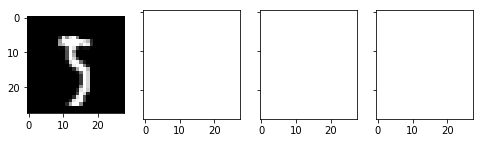

------------------


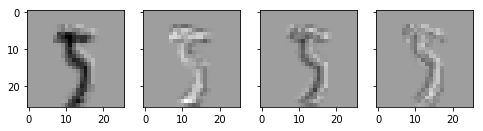

------------------


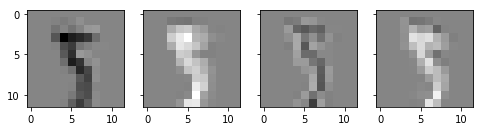

------------------


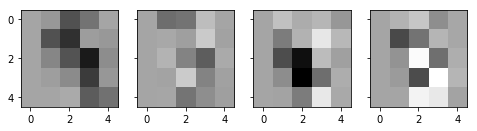

------------------


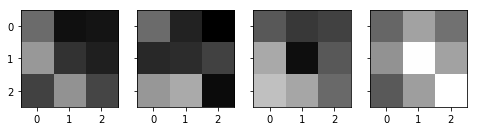

------------------


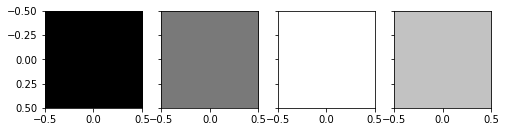

=========== 2 =============
------------------


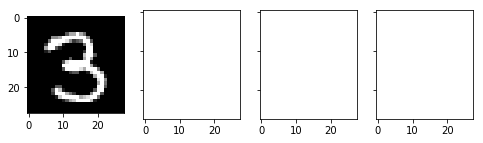

------------------


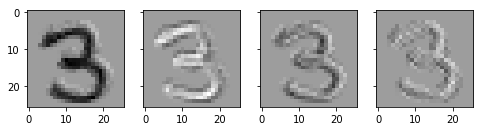

------------------


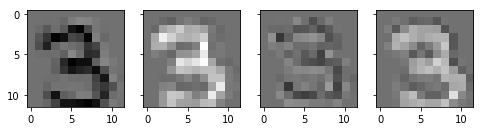

------------------


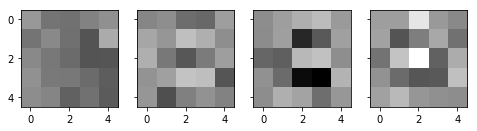

------------------


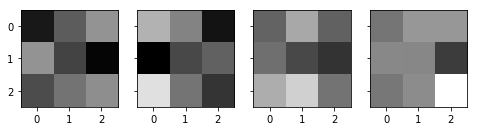

------------------


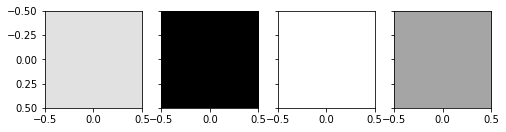

=========== 3 =============
------------------


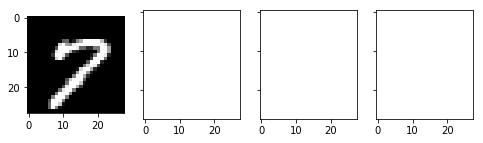

------------------


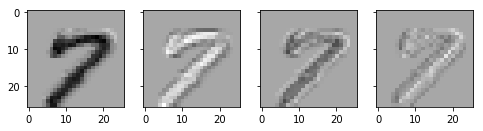

------------------


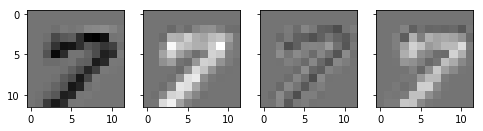

------------------


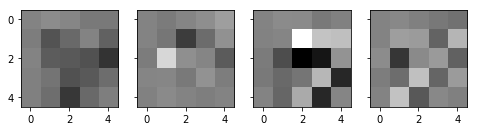

------------------


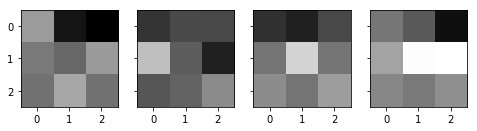

------------------


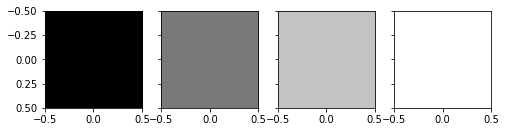

=========== 4 =============
------------------


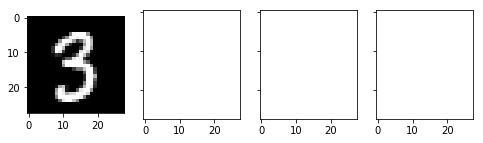

------------------


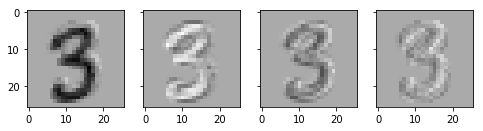

------------------


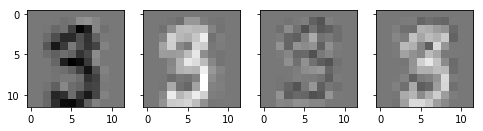

------------------


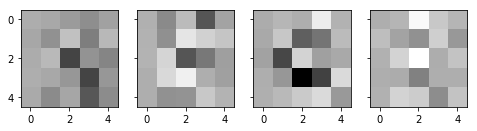

------------------


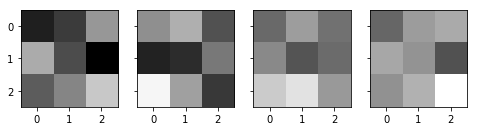

------------------


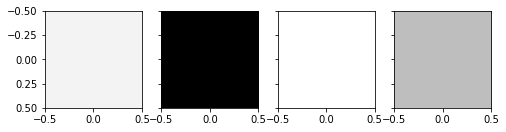

=========== 5 =============
------------------


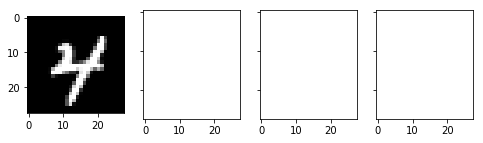

------------------


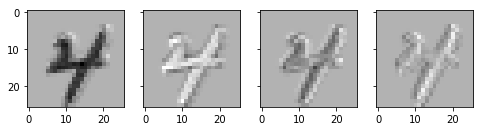

------------------


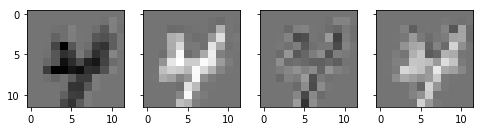

------------------


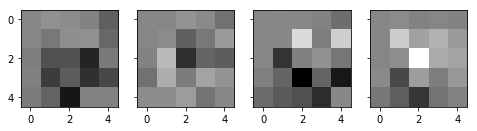

------------------


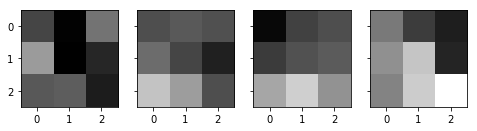

------------------


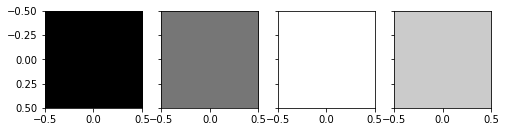

=========== 6 =============
------------------


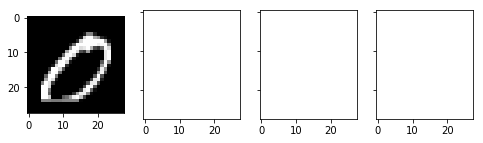

------------------


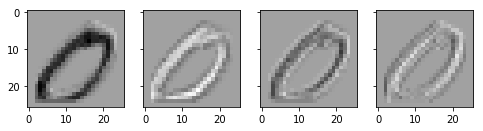

------------------


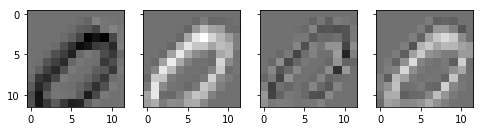

------------------


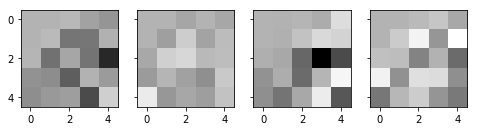

------------------


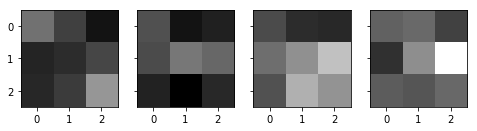

------------------


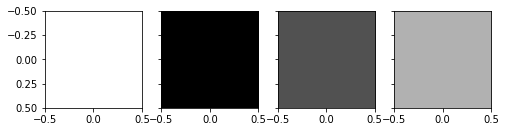

In [94]:
count= 0

for data, label in train_loader:
    count += 1
    print("=========== {} =============".format(count))
    data = data.to(device)
    Ys = forward(Ls, data, full=True)
    for y in Ys:
        print("------------------")
#         print(y.shape)
        fig, ax = plt.subplots(1,4, sharex=True, sharey=True, figsize=(8, 2))
        vmin = y[0,:].min().item()
        vmax = y[0,:].max().item()
        for i in range(y.shape[1]):
            py = i%4
            ax[py].imshow(y[0,i].cpu().numpy(), cmap='gray', vmin=vmin, vmax=vmax)
        plt.show()
        
    if (count > 5):
        break
            

    

tensor([[-0.1743, -0.1930, -0.2472, -0.4166],
        [-0.1359, -0.5030, -0.1903,  0.4387],
        [-0.7121,  0.2233, -0.0172, -0.0954],
        [-0.1284,  0.2466,  0.7593,  0.1997],
        [-0.2987,  0.1987, -0.2920, -0.2841],
        [ 0.2314,  0.6116, -0.2721, -0.0360],
        [ 0.4172, -0.0780, -0.1591,  0.0045],
        [-0.3212, -0.0056, -0.2570,  0.5415],
        [-0.0878, -0.4237,  0.2743, -0.4580]], device='cuda:3')


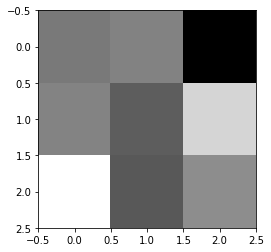

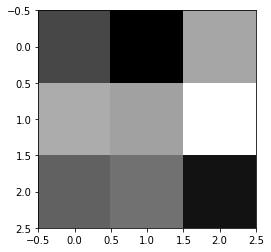

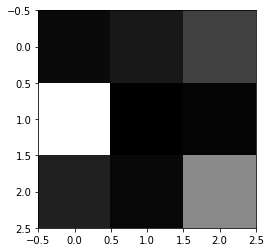

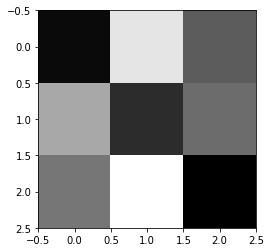

In [98]:


L = Ls[0]
T = L.params()
print (T)
T = T.transpose(0,1).contiguous().view(4,3,3)
for i in range(4):
    plt.imshow(T[i].cpu().numpy(), cmap='gray')
    plt.show()


In [102]:
Ls = makeNet(device, Gs=[4,4,4,4,4], eta=1e-4, gamma=0)
hardpre = []
for i in range(len(Ls)):
    hardpre.append(MeasureHardness(Ls[:i+1], 30, train_loader, epochs=5, lr=5e-3, verbose=False))
    print ("Layer {}: {}".format(i, hardpre[-1]))
    
hard = train(Ls, train_loader, 1, 20, layer_learn=False, hardness=False, verbose=True)

hardpost = []
for i in range(len(Ls)):
    hardpost.append(MeasureHardness(Ls[:i+1], 30, train_loader, epochs=5, lr=5e-3))
    print ("Layer {}: {}".format(i, hardpost[-1]))
    
print ()
for i in range(5):
    h1 = hardpre[i]
    h2 = hardpost[i]
    print ("Layer {}: {:.4f} -> {:.4f}".format(i,h1,h2))

Layer 0: 0.9069933147281409
Layer 1: 0.9111166478587933
Layer 2: 0.8788099802260594
Layer 3: 0.7790533135533324
Layer 4: 0.3886633235532792
Gathering Initial Statistics...
Round: 1/1
Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Round 0 runtime: 251.46984195709229

Layer 0: 0.9099033147481578
Layer 1: 0.9117966488053397
Layer 2: 0.8810033141722277
Layer 3: 0.8293033126244922
Layer 4: 0.3721199908380708

Layer 0: 0.9070 -> 0.9099
Layer 1: 0.9111 -> 0.9118
Layer 2: 0.8788 -> 0.8810
Layer 3: 0.7791 -> 0.8293
Layer 4: 0.3887 -> 0.3721
